# INTELIGENCIA ARTIFICIAL (1INF24)
## (Primer Semestre 2025)

# Laboratorio 1: Búsqueda sin Informacion

## Indicaciones generales:

- Duración: **120 minutos (2 horas)**.
- Las respuestas deben contar con **fundamento teórico**.
- Cualquier indicio de plagio resultará en la anulación de la prueba.
- Debe presentar sus respuestas en base a los resultados de ejecución en los casos que se solicite. **No se calificarán aquellas respuestas que no presenten un resultado de ejecución o que no concuerden con este**.
- Subir el cuadernillo con el nombre **lab-01_código.ipynb**, donde código es su código PUCP de 8 dígitos.
- <font color='red'>Está prohibido el uso de herramientas de IA generativa (ChatGpt, Cloude, Gemini, etc.)</font>. En caso se detecte el uso de estas herramientas la calificación será 00.
- No está permitido el uso de material de clase.

Objetivos:
- Especificar problemas como búsquedas en espacios de estados.
- Comparar los diferentes métodos de búsqueda sin información.
- Plantear alternativas de modelos de búsqueda ante las diferentes dificultades que se puedan generar.
- Relacionar los conceptos aprendidos sobre problemas de búsqueda sin información con escenarios de la vida cotidiana.



## Caso: Maquina de Sellos
Una empresa fabrica maquinas selladoras automáticas para colegios, estas maquinas pueden sellar calificaciones en hojas de examenes. Las notas que puede sellar van desde A (excelente), B (bueno), C (regular), D (en inicio) y F (desaprobado). Además, puede sellar los caracteres especiales "O" para indicar que la evaluación del alumno fue anulada y "Z" para indicar que el alumno no asistió.

La maquina esta compuesta por 8 compartimientos dispuestos en 4 filas y 2 columnas. En cada compartimiento se coloca el sello de una nota. Dado que son 7 notas, un compartimiento siempre queda desocupado. Para que la maquina coloque  las notas correctamente los sellos deben estar en una disposicion especifica, como se muestra en la figura. Sin embargo, cuando  los sellos se gastan estos son reemplazados por los profesores, quienes suelen colocar los sellos en disposicion incorrecta, haciendo que las notas se sellen de forma errada. En vista de ello, la empresa esta implementando un mecanismo para que los sellos se reordenen de forma automatica. Este mecanismo permite mover un sello a la vez a la posicion desocupada.


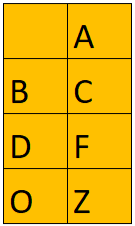

Los ingenieros encargados han avanzado una implementacion de un simulador de la maquina selladora (clase CompartmentEnvironment) y un Agente de busqueda para interactuar en él.  Usted ha sido contratado para terminar de implementar el software que haga la planificacion de la secuencia de movimientos de los sellos que permita ordenarlos a la dispocion correcta desde cualquier disposicion arbitraria de los sellos. Usted decide usar algoritmos de busqueda estudiados en su curso de IA. Para ello decide representar el estado de la maquina como una cadena de caracteres de longitud 8 cuyos 2 primeros elementos corresponden a la primera fila de sellos, los 2 siguientes a la segunda fila y así hasta la cuarta fila.  El carácter "+" simboliza el espacio desocupado. Asi, la disposicion de sellos deseada (estado objetivo) se representa como **"+ABCDFOZ"**

Algunas partes del código se encuentran incompletas con la palabra "COMPLETAR", por lo que deberá analizar el algoritmo y completar las partes faltantes. Las celdas con el texto **"No modificar"** no deben ser alteradas. Al final del cuadernillo se encuentra el cuestionario a responder en el presente laboratorio.
Se brindan las clases utilitarias que permitirán resolver el problema de reordenamiento.

## Clase Thing

Esta clase genérica representa cualquier objeto físico que puede aparecer en un ambiente.<br>
**( No modificar )**  

In [14]:
class Thing(object):
    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

## Clase Agent

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la función que implementa el <b>programa del agente</b>. Esta función debe tomar como argumento la <b>percepción</b> del agente y debe retornar una <b>acción</b>. La definición de Percepción y Acción depende del ambiente de trabajo (environment) donde el agente existe. El agente también puede tener el slot <b>.performance</b>, que guarda el desempeño del agente en su ambiente (desempeño visto desde el agente).<br>
**( No modificar )**

In [15]:
import collections
import random

class Agent(Thing):
    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        assert isinstance(program, collections.Callable)
        self.program = program

## Clase Environment

Esta clase abstracta representa un entorno de tareas. Clases de entornos reales heredan de esta. En un entorno típicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y
<b>execute_action</b>, que define los efectos de ejecutar una acción.
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location.<br>
**( No modificar )**

In [16]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepción que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una acción 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localización especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningun agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade una cosa thing al entorno en la localización location.
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No añade la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)

    def step(self):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

## Clase CompartmentEnvironment

1.   Elemento de la lista
2.   Elemento de la lista



En esta clase se implementa el entorno del compartimiento. El caracter '+' representa la posición del mecanismo de entrada.<br>
**( Llenar donde se indica COMPLETAR )**

In [17]:
class CompartmentEnvironment(Environment):

    def __init__(self, initial_state):
        super().__init__()
        self.status = initial_state

    def thing_classes(self):
        return [CompartmentReflexAgent]

    def percept(self, agent):
        """Retorna el estado del ambiente (las piezas que estan en cada posicion)"""
        return self.status

    def execute_action(self, agent, action):
        """Implementa el MAPA De TRANSICION: Cambia la posición de los sellos de acuerdo a la acción solicitada
        del espacio libre.
        Cada acción válida debe provocar una disminución de desempeño en 1 unidad """

        ################################# COMPLETAR ###############################################

        # Debe completar las validaciones para cada acción válida
        # Recuerde que la implementación del compartimento es mediante una tupla de 8 elementos
        # en la que cada 2 elementos representa una fila.

        ###########################################################################################

        state = list(self.status)
        iblank = state.index('+')    # Obtiene el indice del casillero en blanco (representado con '+')

        if action == 'Right':
            if ((iblank + 1) % 2 != 0):
                state[iblank] , state[iblank+1] =  state[iblank+1],  state[iblank]
                agent.performance -= 1

        elif action == 'Left':
            if (iblank % 2 != 0):
                state[iblank-1], state[iblank] = state[iblank], state[iblank-1]
                agent.performance -= 1

        elif action == 'Up':
            if (iblank > 1):
                state[iblank-2], state[iblank] = state[iblank], state[iblank-2]
                agent.performance -= 1

        elif action == 'Down':
            if (iblank < 6):
                state[iblank], state[iblank+2] = state[iblank+2], state[iblank]
                agent.performance -= 1

        self.status = ''.join(state)


    def print_state(self):   # imprime el estado de la disposicion de los sellos

        for i in range(4):
            print(" "*20 + "|  " + self.status[2*i] + "   " + self.status[2*i+1] + "  |\n"  )



## Clase SearchProblem

Esta es una clase abstracta para definir problemas de búsqueda. Se debe hacer subclases que implementen los métodos de las acciones, resultados, test de objetivo y el costo de camino. Entonces se puede instanciar las subclases y resolverlos con varias funciones de búsqueda.<br>
**( No modificar )**

In [18]:
class SearchProblem(object):
    def __init__(self, initial, goal=None):
        """Este constructor especifica el estado inicial y posiblemente el estado(s) objetivo(s),
        La subclase puede añadir mas argumentos."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones que pueden ser ejecutadas en el estado dado.
        El resultado es tipicamente una lista."""
        raise NotImplementedError

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada en el estado state.
        La accion debe ser alguna de self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Retorna True si el estado pasado satisface el objetivo."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con
        la accion action, asumiendo un costo c para llegar hasta state1.
        El metodo por defecto cuesta 1 para cada paso en el camino."""
        return c + 1

    def value(self, state):
        """En problemas de optimizacion, cada estado tiene un valor. Algoritmos
        como Hill-climbing intentan maximizar este valor."""
        raise NotImplementedError

## Clase CompartmentSearchProblem  
Esta es una subclase de SearchProblem donde se definirá concretamente el problema de búsqueda para el ambiente del compartimento. **Se necesitan completar algunas validaciones en los metodos actions() y result() .**

In [19]:
class CompartmentSearchProblem(SearchProblem):

    def __init__(self, initial, goal):
        """El constructor recibe  el estado inicial y el estado objetivo"""
        self.initial = initial
        self.goal = goal


    def actions(self, state):
        """Retorna las acciones ejecutables desde el estado state.
           Recuerde que se debe retornar una LISTA de acciones, es decir, puede haber más de una acción válida
           desde un estado dado."""

        acciones = []
        iblank = state.index('+')   # Obtiene el indice del casillero en blanco (representado con '+') del estado

        ################################# COMPLETAR ###############################################

        # Debe obtener las acciones válidas para el estado dado.
        # No olvide las condiciones que se deben cumplir para que una acción sea válida.

        ###########################################################################################

        if ((iblank + 1) % 2 != 0):
            acciones.append("Right")
        if (iblank % 2 != 0):
            acciones.append("Left")
        if (iblank > 1):
            acciones.append("Up")
        if (iblank < 6):
            acciones.append("Down")

        return acciones


    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion action desde state.
        La accion debe ser alguna de self.actions(state)
        Por ejemplo, para  state='+ABCDEFOZ' y action='Right' debe retornar newState = 'A+BCDEFOZ' """

        ################################# COMPLETAR ###############################################

        # Debe completar las validaciones para cada acción válida
        # Pista: Las validaciones son las mismas que implementó en el ambiente del compartimento.

        ###########################################################################################

        iblank = state.index('+')    # obtiene el indice del casillero en blanco (representado con +) del estado
        newState = list(state)       # copia state en una lista newState

        if action == 'Right':
            if ((iblank + 1) % 2 != 0):
                newState[iblank], newState[iblank+1] = newState[iblank+1], newState[iblank]

        elif action == 'Left':
            if (iblank % 2 != 0):
                newState[iblank-1], newState[iblank] = newState[iblank], newState[iblank-1]

        elif action == 'Up':
            if (iblank > 1):
                newState[iblank-2], newState[iblank] = newState[iblank], newState[iblank-2]

        elif action == 'Down':
            if (iblank < 6):
                newState[iblank], newState[iblank+2] = newState[iblank+2], newState[iblank]

        return ''.join(newState)


    def goal_test(self, state):
        """Retorna True si state es self.goal"""
        return (self.goal == state)


    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con la acción action
        El costo del camino para llegar a state1 es c. El costo de la acción es = 1"""
        return c + 1;

## Clase Node

Estructura de datos para almacenar la información de un nodo en un <b>árbol de búsqueda</b>. Contiene información del nodo padre y el estado que representa el nodo. Tambien incluye la acción que nos llevó al presente nodo y el costo total del camino desde el nodo raíz hasta este nodo.<br>
**( No modificar )**

In [20]:
class Node:

    def __init__(self, state, parent=None, action=None, path_cost=0):
        "Crea un nodo de árbol de búsqueda, derivado del nodo parent y acción action"
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1


    def expand(self, problem):
        "Devuelve los nodos alcanzables en un paso a partir de este nodo."
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]


    def child_node(self, problem, action):
        next = problem.result(self.state, action)
        return Node(next, self, action,
                    problem.path_cost(self.path_cost, self.state, action, next))


    def solution(self):
        "Retorna la secuencia de acciones para ir de la raiz a este nodo."
        return [node.action for node in self.path()[1:]]


    def path(self):
        "Retorna una lista de nodos formando un camino de la raiz a este nodo."
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))


    def __lt__(self, node):
        return self.state < node.state


    def __eq__(self, other):
        "Este metodo se ejecuta cuando se compara nodos. Devuelve True cuando los estados son iguales"
        return isinstance(other, Node) and self.state == other.state


    def __repr__(self):
        return "<Node {}>".format(self.state)


    def __hash__(self):
        return hash(self.state)

## <b> Define una cola tipo FIFO First-In-First-Out (para BFS)</b>
**( No modificar )**

In [21]:
from collections import deque

class FIFOQueue(deque):
    """Una cola First-In-First-Out"""
    def pop(self):
        return self.popleft()

## Algoritmo general de búsqueda con memoria de nodos expandidos (Graph Search)

Algoritmo general de búsqueda ciega con memoria de estados visitados. El argumento frontier debe ser una cola vacia. Si  frontier es tipo FIFO hace busqueda en amplitud (BFS), si la frontier es una pila hará busqueda en profundidad (DFS). Devuelve el nodo solucion y una lista de nodos visitados durante la búsqueda.<br>
**( No modificar )**

In [22]:
def graph_search(problem, frontier):
    frontier.append(Node(problem.initial))
    print(problem.initial)
    explored = set()     # Memoria de estados visitados
    visited_nodes = []   # Almacena nodos visitados durante la búsqueda
    while frontier:
        node = frontier.pop()
        visited_nodes.append(node)
        if problem.goal_test(node.state):
            return node, visited_nodes
        explored.add(node.state)

        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None

## Clase que implementa el programa del agente de búsqueda en el entorno del compartimento
**( No modificar )**

In [23]:
class CompartmentSearchProgram:
    def __init__(self, goal_state, search_method):
        self.goal = goal_state
        self.method = search_method
        self.seq = []  # Lista de acciones a ejecutar, inicialmente vacía.

    def __call__(self, percept):
        state = percept
        if state == self.goal:    # Si el ambiente se encuentra en el estado objetivo, no hace nada.
            return 'None'

        if not self.seq:          # Si la lista de acciones esta vacía.

            print('- El agente buscará una solución al problema del ordenamiento de sellos:\n  Estado Inicial  = {}\n  Estado Objetivo = {}'.format(state,self.goal))

            search_problem = CompartmentSearchProblem(state, self.goal)

            if self.method == 'bfs':
                print(search_problem)
                goal_node, visited_nodes = graph_search(search_problem, FIFOQueue()) # Frontera es una cola FIFO

            elif self.method == 'dfs':
                goal_node, visited_nodes = graph_search(search_problem, []) # Frontera es una pila

            else:
                raise NotImplementedError

            if goal_node == None: # No se encuentra solución
                print('  No se encontró solución para el problema del ordenamiento de sellos con método {}\n'
                      .format(self.method) )
                return 'None'

            self.seq = goal_node.solution()

            print('  Agente planeó una solución al problema del ordenamiento de sellos con {}:\n  Secuencia de acciones = {}\n  Nodos visitados = {}\n  Costo Solución  = {}\n'
                  .format(self.method, self.seq, len(visited_nodes), goal_node.path_cost) )

        action = self.seq.pop(0)

        return action

## Probando el entorno de parqueo vehicular y agente de búsqueda
A continuación se brinda código referencial para probar y visualizar los resultados.<br>

**Este código podrá ser reutilizado posteriormente para las pruebas donde se requiera probar algún método de búsqueda.** <br>

**IMPORTANTE:** Recuerde instanciar todos los objetos necesarios para cada prueba.

In [24]:
collections.Callable = collections.abc.Callable

In [27]:
# ========================================================
#                     Prueba para BFS
# ========================================================

"""Crea el entorno del problema del ordenamiento de sellos con el adecuado estado inicial."""
e = CompartmentEnvironment("OBD+FZCA")

"""Crea un agente de busqueda para alcanzar goalstate con metodo de busqueda bfs"""
goalstate = "+ABCDFOZ"
a = Agent( CompartmentSearchProgram (goalstate, 'bfs') )

print("-"*50)
print("Estado inicial del ambiente del compartimento:")
print("-"*50 + "\n")
e.print_state()
print("-"*80 + "\n")

"""Añade el agente creado al entorno"""
e.add_thing(a)

# Ejecuta el entorno 30 pasos
e.run(30)

print("-"*80)
print("Estado final del ambiente del compartimento:")
print("-"*50 + "\n")
e.print_state()

--------------------------------------------------
Estado inicial del ambiente del compartimento:
--------------------------------------------------

                    |  O   B  |

                    |  D   +  |

                    |  F   Z  |

                    |  C   A  |

--------------------------------------------------------------------------------

- El agente buscará una solución al problema del ordenamiento de sellos:
  Estado Inicial  = OBD+FZCA
  Estado Objetivo = +ABCDFOZ
OBD+FZCA
  Agente planeó una solución al problema del ordenamiento de sellos con bfs:
  Secuencia de acciones = ['Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up']
  Nodos visitados = 13215
  Costo Solución  = 24

--------------------------------------------------------------------------------
Estado final del ambiente del compartimento:
---------------------------------------

## Cuestionario

**1.** Completar el código faltante con las etiquetas **"COMPLETAR"** en las clases CompartmentEnviroment, CompartmentSearchProblem. **(5 ptos)** <br>

**Rpta:** Ya está  

**2.** Cree una función para poder ejecutar el programa de manera compacta. Y pruébela para los métodos DFS y BFS. Esta funcion puede asumir que los parámetros que se le pasan son siempre correctos, la función vacía esta aquí. Ejecute la funcion con estado inicial OBD+FZCA y estado objetivo +ABCDFOZ y métodos dfs y bfs **(2 punto)**:

In [32]:
def runProgram(initialstate, goalstate, numsteps, method):
  # 1) Crear entorno con el estado inicial
    e = CompartmentEnvironment(initialstate)
    # 2) Crear agente con el programa de búsqueda indicado ('dfs' o 'bfs')
    a = Agent(CompartmentSearchProgram(goalstate, method))
    # 3) Añadir agente y correr
    e.add_thing(a)
    print(f"[{method.upper()}] INICIAL:", e.status)
    e.run(numsteps)
    print(f"[{method.upper()}] FINAL:  ", e.status)
    return e.status

In [33]:
#Llamado a la funcion con DFS:
runProgram(initialstate="OBD+FZCA", goalstate="+ABCDFOZ", numsteps=1000000, method='dfs')

[DFS] INICIAL: OBD+FZCA
- El agente buscará una solución al problema del ordenamiento de sellos:
  Estado Inicial  = OBD+FZCA
  Estado Objetivo = +ABCDFOZ
OBD+FZCA
  Agente planeó una solución al problema del ordenamiento de sellos con dfs:
  Secuencia de acciones = ['Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up', 'Right', '

'+ABCDFOZ'

In [34]:
#Llamado a la funcion con BFS:
runProgram(initialstate="OBD+FZCA", goalstate="+ABCDFOZ", numsteps=50, method='bfs')

[BFS] INICIAL: OBD+FZCA
- El agente buscará una solución al problema del ordenamiento de sellos:
  Estado Inicial  = OBD+FZCA
  Estado Objetivo = +ABCDFOZ
OBD+FZCA
  Agente planeó una solución al problema del ordenamiento de sellos con bfs:
  Secuencia de acciones = ['Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up']
  Nodos visitados = 13215
  Costo Solución  = 24

[BFS] FINAL:   +ABCDFOZ


'+ABCDFOZ'

**3.** ¿Cuál método encuentra la secuencia de acciones más corta? ¿Por qué? **(2 punto)**

In [ ]:
"""
  El método que encuentra la secuencia de acciones más corta es BFS (Breadth-First Search).
Esto ocurre porque BFS explora los estados por niveles, es decir, primero revisa todos los nodos a una determinada profundidad antes de pasar a la siguiente. Como todos los pasos tienen el mismo costo (=1), el primer momento en que BFS alcanza el estado objetivo necesariamente corresponde al camino con la menor cantidad de acciones posibles.

En cambio, DFS se va por un camino profundo sin importar su longitud, y puede encontrar soluciones mucho más largas o incluso perderse en ramas inútiles.
"""

**Rpta:**

**4.** ¿cuáles son los valores **b** y **d** del árbol de busqueda en el problema experimentado (initialstate="OBD+FZCA" y goalstate="+ABCDFOZ")  ? **(2 punto)**

**Rpta:** b= 2.5 y d=24

**5.** ¿cuál sería el valor **m** del árbol de búsqueda si se estuviera usando búsqueda de árbol (sin memoria de estados visitados) ? **(1 punto)**

**Rpta:**

**6.** Si se cuenta con memoria muy limitada, ¿cuál método de busqueda seria recomendable usarse? ¿Por qué? **(2 punto)**

**Rpta:** infinita

**7.** Implementar Agoritmo Breath-First-Search, indicado abajo y probarlo, para ello ejecutar:  **(4 punto)**

    runProgram(initialstate="OBD+FZCA", goalstate="+ABCDFOZ", numsteps=50, method='breadth_first_search'))

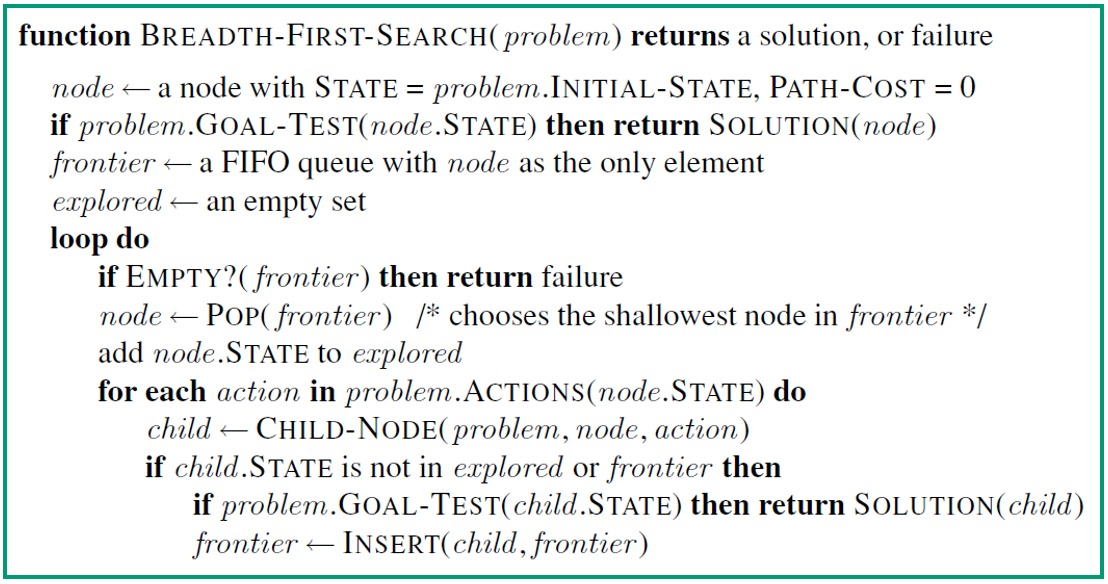

In [42]:
def breadth_first_search(problem):
    """
    BFS clásico (árbol/grafo con memoria de visitados).
    Retorna (goal_node, visited_nodes), donde visited_nodes es una lista de nodos
    en el orden en que fueron extraídos de la frontera.
    """
    # Nodo raíz
    root = Node(problem.initial)
    # Chequear si ya estamos en la meta
    if problem.goal_test(root.state):
        return root, [root]

    # Frontera FIFO con solo la raíz
    frontier = FIFOQueue()
    frontier.append(root)

    explored = set()       # memoria de estados visitados
    visited_nodes = []     # historial de nodos extraídos de la frontera

    while frontier:
        node = frontier.pop()          # Paso 6: saca el más superficial (FIFO)
        visited_nodes.append(node)    # (opcional) registro de visita

        if problem.goal_test(node.state):
           return node, visited_nodes



        # Generar hijos
        for child in node.expand(problem):
            # evitar re-expansión de estados ya vistos o ya en la frontera
            if (child.state not in explored) and (child not in frontier):
                if problem.goal_test(child.state):
                    visited_nodes.append(child)
                    return child, visited_nodes
                frontier.append(child)

    # Si se vacía la frontera sin hallar solución
    return None, visited_nodes



class CompartmentSearchProgram:
    def __init__(self, goal_state, search_method):
        self.goal = goal_state
        self.method = search_method
        self.seq = []  # Lista de acciones a ejecutar, inicialmente vacía.

    def __call__(self, percept):
        state = percept
        if state == self.goal:    # Si el ambiente se encuentra en el estado objetivo, no hace nada.
            return 'None'

        if not self.seq:          # Si la lista de acciones esta vacía.

            print('- El agente buscará una solución al problema del ordenamiento de sellos:\n  Estado Inicial  = {}\n  Estado Objetivo = {}'.format(state,self.goal))

            search_problem = CompartmentSearchProblem(state, self.goal)

            if self.method == 'bfs':
                print(search_problem)
                goal_node, visited_nodes = graph_search(search_problem, FIFOQueue()) # Frontera es una cola FIFO

            elif self.method == 'dfs':
                goal_node, visited_nodes = graph_search(search_problem, []) # Frontera es una pila

            elif self.method == 'breadth_first_search':
                goal_node, visited_nodes = breadth_first_search(search_problem) # busqueda  breadth_first_search
            else:
                raise NotImplementedError

            if goal_node == None: # No se encuentra solución
                print('  No se encontró solución para el problema del ordenamiento de sellos con método {}\n'
                      .format(self.method) )
                return 'None'

            self.seq = goal_node.solution()

            print('  Agente planeó una solución al problema del ordenamiento de sellos con {}:\n  Secuencia de acciones = {}\n  Nodos visitados = {}\n  Costo Solución  = {}\n'
                  .format(self.method, self.seq, len(visited_nodes), goal_node.path_cost) )

        action = self.seq.pop(0)

        return action



# Prueba el agente con metodo breadth_first_search:
runProgram(initialstate="OBD+FZCA", goalstate="+ABCDFOZ", numsteps=50, method='breadth_first_search')

[BREADTH_FIRST_SEARCH] INICIAL: OBD+FZCA
- El agente buscará una solución al problema del ordenamiento de sellos:
  Estado Inicial  = OBD+FZCA
  Estado Objetivo = +ABCDFOZ
  Agente planeó una solución al problema del ordenamiento de sellos con breadth_first_search:
  Secuencia de acciones = ['Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Down', 'Left', 'Up', 'Up', 'Right', 'Down', 'Down', 'Left', 'Up', 'Up', 'Up']
  Nodos visitados = 30198
  Costo Solución  = 24

[BREADTH_FIRST_SEARCH] FINAL:   +ABCDFOZ


'+ABCDFOZ'

:**8.** ¿Por qué es ventajoso Breath_First_Search en relacion a BFS con graph_search?  **(2 punto)**

In [43]:
"""

Es ventajoso usar breadth_first_search porque es un algoritmo especializado que
implementa directamente la búsqueda en anchura, lo que lo hace más eficiente y
claro que usar graph_search con una cola FIFO. graph_search es más genérico y
flexible, pero tiene mayor sobrecarga. En cambio, breadth_first_search está
optimizado solo para BFS y garantiza encontrar siempre la solución mínima en pasos.

"""

'\n\nEs ventajoso usar breadth_first_search porque es un algoritmo especializado que \nimplementa directamente la búsqueda en anchura, lo que lo hace más eficiente y \nclaro que usar graph_search con una cola FIFO. graph_search es más genérico y \nflexible, pero tiene mayor sobrecarga. En cambio, breadth_first_search está \noptimizado solo para BFS y garantiza encontrar siempre la solución mínima en pasos.\n\n'